## 군집 특성 추론

데이터 로드

In [2]:
import pandas as pd

pca_result = pd.read_csv('./data/minmax_scaling_PCA_label.csv', index_col=0)
scaled_df = pd.read_csv('./data/minmax_scaling.csv', index_col=0)
original_df = pd.read_csv('./data/final_data_after_winsorization.csv', index_col=0)

1. boxplot으로 시각화해서 각 군집의 특성을 추론하기

In [3]:
# 시각화 폰트 깨지는 오류 디버깅
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import os

# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

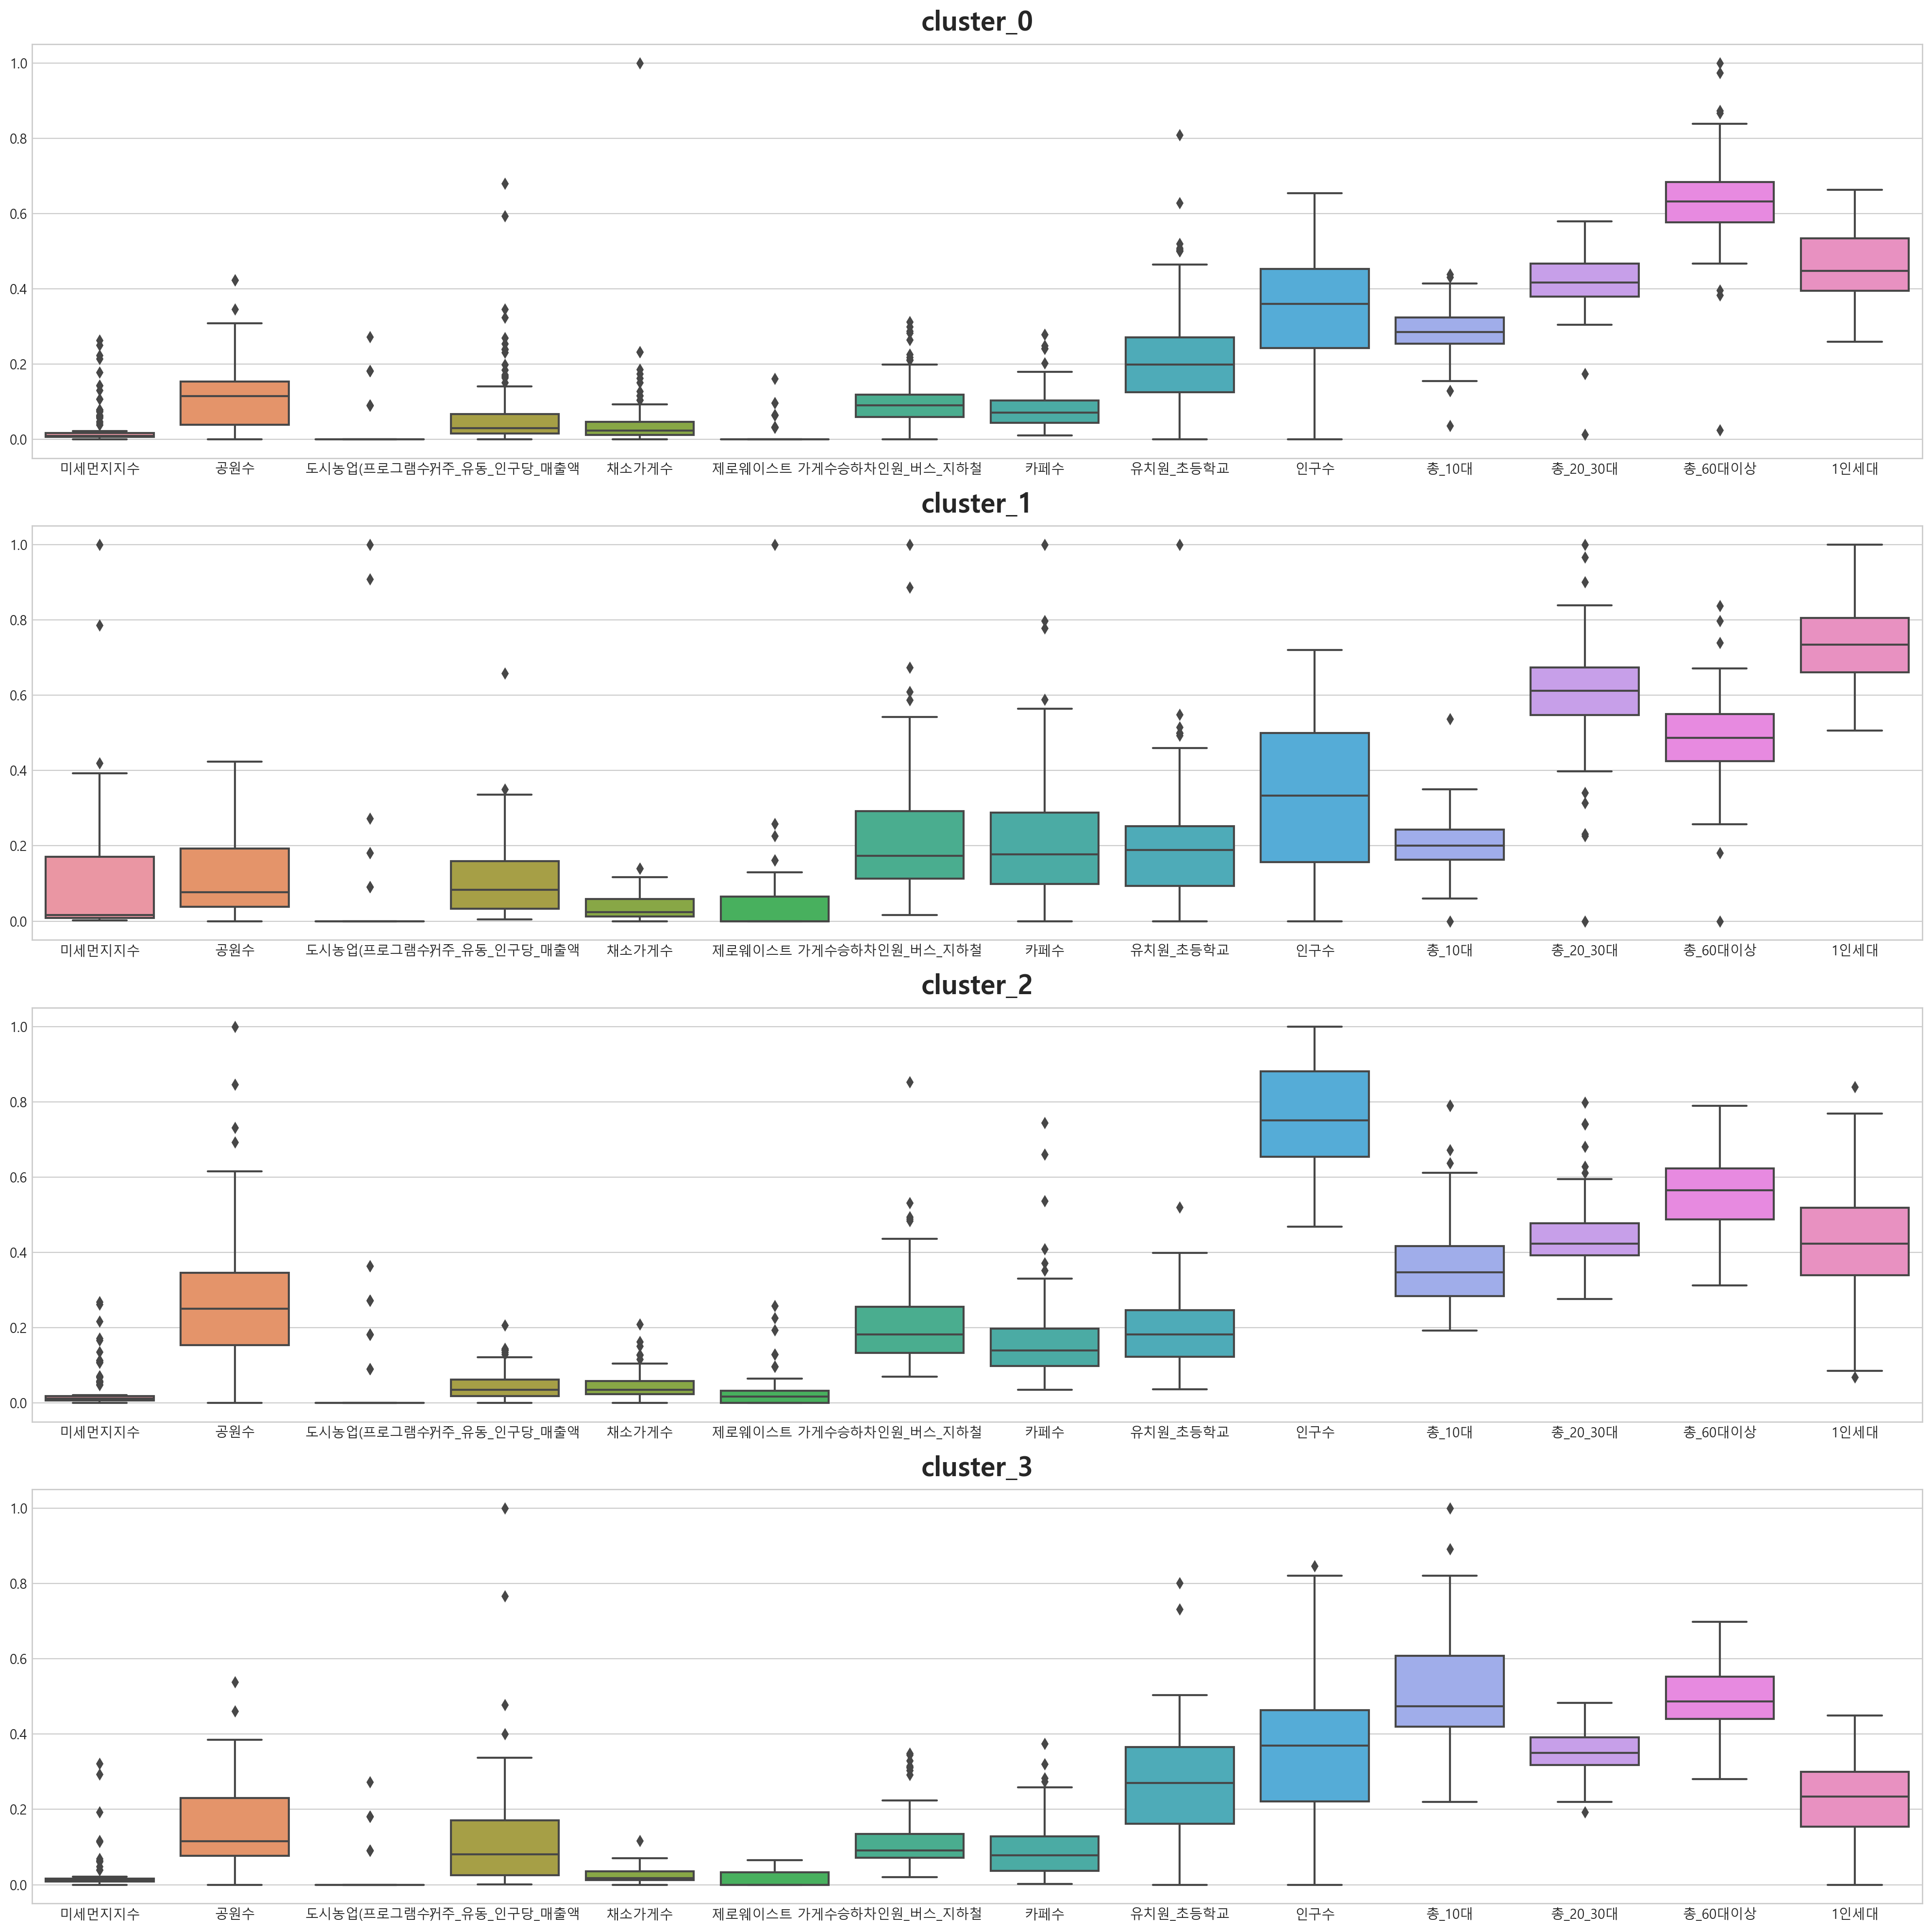

In [4]:
import seaborn as sns

fig , axes = plt.subplots(nrows=4 ,ncols=1,
                          figsize=(20,20) )
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, 
                    top=0.99, wspace=None, hspace=0.2)
ax = axes.flatten()

for i in range(len(pca_result['cluster'].unique())):
    sns.boxplot(data=scaled_df.loc[pca_result[pca_result['cluster'] == i].index, :], ax = ax[i])
    ax[i].set_title(f"cluster_{i}", fontsize= 20)

plt.show()

2. parallel_coordinates로 시각화해서 각 군집의 특성 추론하기

In [5]:
# minmax scaled data에 클러스터링 레이블 컬럼 추가
scaled_df_label = pd.concat([scaled_df.loc[pca_result[pca_result['cluster'] == i].index, :]
    for i in range(len(pca_result['cluster'].unique()))])

scaled_df_label = scaled_df_label.join(pca_result['cluster'], on='행정동명')
scaled_df_label.sample(3)

미세먼지지수       공원수  도시농업(프로그램수)  거주_유동_인구당_매출액     채소가게수  제로웨이스트 가게수  \
행정동명                                                                         
가회동   0.107144  0.038462          0.0       0.593604  0.023256    0.032258   
이촌2동  0.021339  0.038462          0.0       0.009984  0.011628    0.161290   
대림2동  0.011834  0.038462          0.0       0.015014  0.058140    0.000000   

      승하차인원_버스_지하철       카페수  유치원_초등학교       인구수     총_10대  총_20_30대  \
행정동명                                                                   
가회동       0.061756  0.179803   0.50000  0.000000  0.299526  0.304794   
이촌2동      0.020335  0.017241   0.00000  0.093871  0.263652  0.394575   
대림2동      0.059406  0.041872   0.38468  0.205261  0.191662  0.468311   

       총_60대이상      1인세대  cluster  
행정동명                               
가회동   0.558320  0.519518        0  
이촌2동  0.683317  0.370888        0  
대림2동  0.714126  0.650721        0

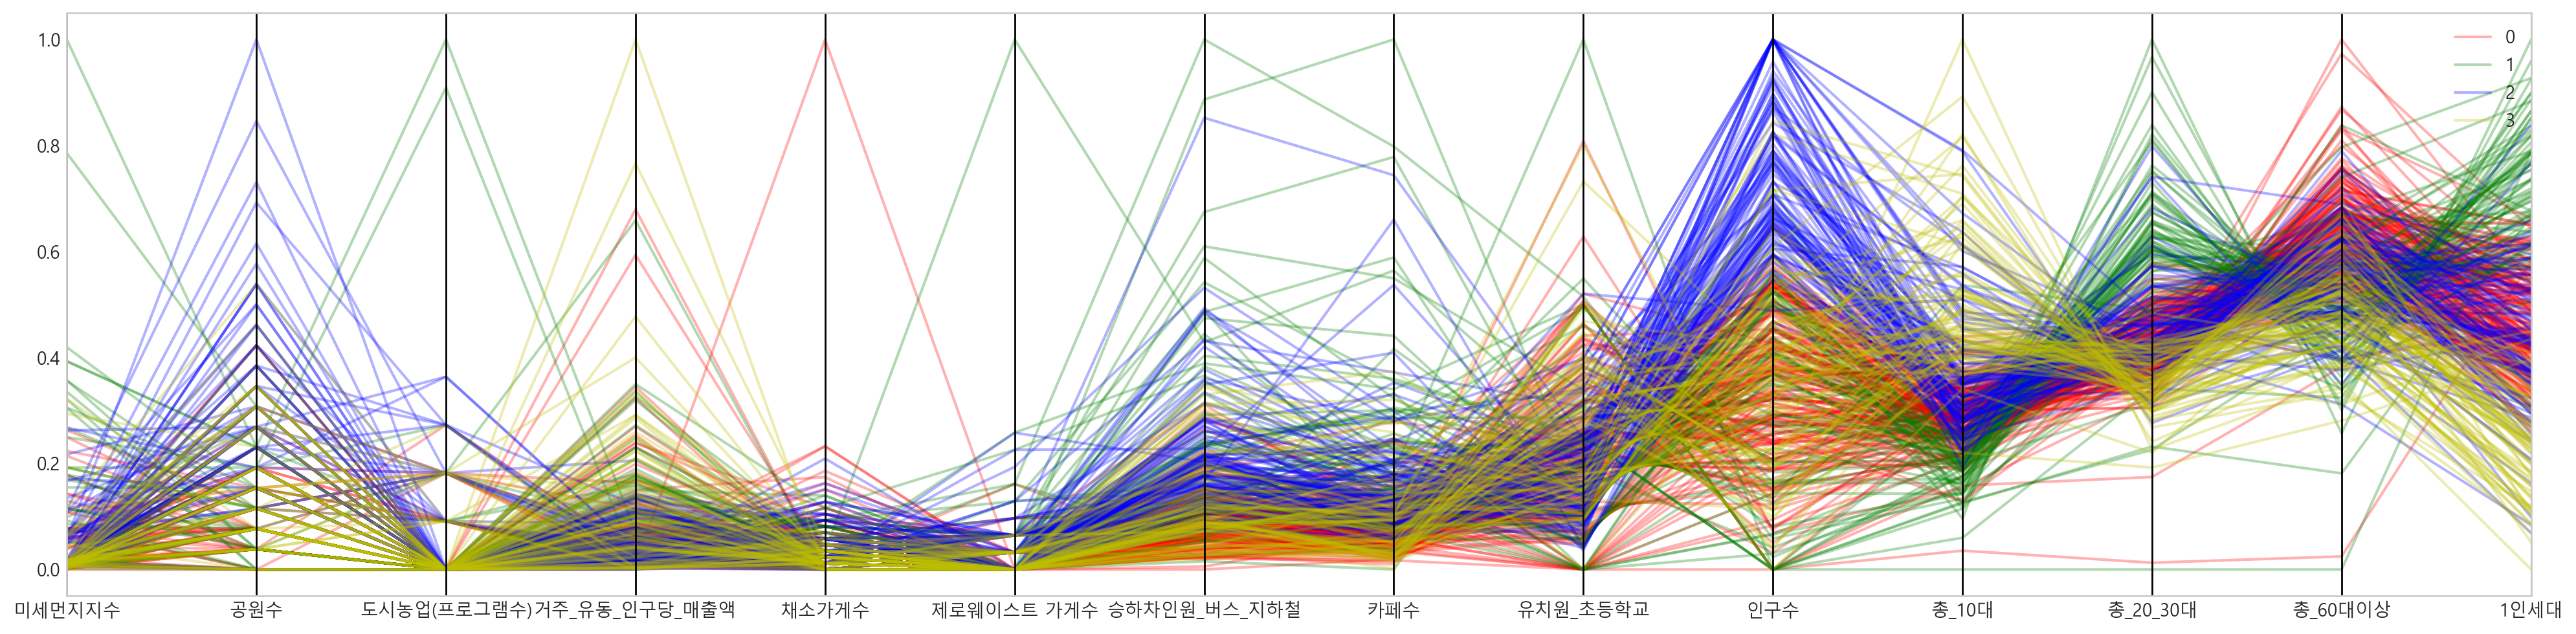

In [6]:
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(20,5))
parallel_coordinates(scaled_df_label, class_column='cluster', 
                     cols=scaled_df_label.drop('cluster', axis=1).columns, 
                     color=['r', 'g', 'b', 'y'], alpha=0.3)
plt.show()

3. RandomForest 모델링을 통해 군집의 특성 추론하기

-  raw data 활용

In [7]:
# feature selection을 통해 필터링한 컬럼
features = ['미세먼지지수', '공원수', '도시농업(프로그램수)', '거주_유동_인구당_매출액', '채소가게수', '제로웨이스트 가게수',
       '승하차인원_버스_지하철', '카페수', '유치원_초등학교', '인구수', '총_10대', '총_20_30대',
       '총_60대이상', '1인세대']

In [8]:
# original data에 클러스터링 레이블 컬럼 추가
original_df_label = pd.concat([original_df.loc[pca_result[pca_result['cluster'] == i].index, :]
    for i in range(len(pca_result['cluster'].unique()))])

original_df_label = original_df_label[features]
original_df_label = original_df_label.join(pca_result['cluster'], on='행정동명')
original_df_label.sample(3)

미세먼지지수  공원수  도시농업(프로그램수)  거주_유동_인구당_매출액  채소가게수  제로웨이스트 가게수  \
행정동명                                                                 
상계3.4동  14.719    5          1.0      11.233501    6.0         1.0   
중계2.3동  14.719    6          0.0      57.328435    0.0         0.0   
묵1동     15.673    6          0.0      23.826968    1.0         2.0   

        승하차인원_버스_지하철   카페수  유치원_초등학교    인구수     총_10대  총_20_30대   총_60대이상  \
행정동명                                                                        
상계3.4동       95711.0  24.0  0.000120  49998  0.071403  0.215969  0.349614   
중계2.3동      297539.0  31.0  0.000137  65870  0.083559  0.233278  0.315227   
묵1동         256735.0  46.0  0.000044  67744  0.087417  0.275390  0.266267   

            1인세대  cluster  
행정동명                       
상계3.4동  0.387676        0  
중계2.3동  0.369599        2  
묵1동     0.376395        2

In [9]:
# randomforest classification을 위한 데이터 준비
original_df_label['binary_cluster_0'] = original_df_label['cluster'].map({0:1, 1:0, 2:0, 3:0})
original_df_label['binary_cluster_1'] = original_df_label['cluster'].map({0:0, 1:1, 2:0, 3:0})
original_df_label['binary_cluster_2'] = original_df_label['cluster'].map({0:0, 1:0, 2:1, 3:0})
original_df_label['binary_cluster_3'] = original_df_label['cluster'].map({0:0, 1:0, 2:0, 3:1})
original_df_label.sample(3)

미세먼지지수  공원수  도시농업(프로그램수)  거주_유동_인구당_매출액  채소가게수  제로웨이스트 가게수  \
행정동명                                                               
문정1동  17.603    4          0.0      32.762107    1.0         0.0   
북아현동  11.848    6          0.0       6.917366    2.0         0.0   
다산동   14.146    3          0.0     253.323354    0.0         0.0   

      승하차인원_버스_지하철   카페수  유치원_초등학교    인구수     총_10대  총_20_30대   총_60대이상  \
행정동명                                                                      
문정1동      159953.0  42.0  0.000051  39256  0.071683  0.313990  0.257438   
북아현동      226394.0  14.0  0.000064  31168  0.065388  0.303709  0.220932   
다산동       105541.0  33.0  0.000112  26806  0.051257  0.325375  0.296277   

          1인세대  cluster  binary_cluster_0  binary_cluster_1  binary_cluster_2  \
행정동명                                                                            
문정1동  0.362652        0                 1                 0                 0   
북아현동  0.394492        0                 1                 0                 0   
다산동   0.487540        0                 1                 0                 0   

      binary_cluster_3  
행정동명                    
문정1동                 0  
북아현동                 0  
다산동                  0

In [10]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def check_feature_importance(df, col):
    clf = RandomForestClassifier(random_state=1)
    clf.fit(df.iloc[:, :-5].values, df[col].values)

    # 가장 중요한 피처의 인덱스 구하기
    sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1] # Reverse sort

    # 가장 중요한 피처의 이름과 weight 구하기
    most_important_features = np.take_along_axis(
        np.array(df.iloc[:, 0:-1].columns.tolist()), 
        sorted_feature_weight_idxes, axis=0)
    most_important_weights = np.take_along_axis(
        np.array(clf.feature_importances_), 
        sorted_feature_weight_idxes, axis=0)

    result = list(zip(most_important_features, most_important_weights))
    return pd.DataFrame(index=most_important_features, data=most_important_weights, columns=['feature importance'])

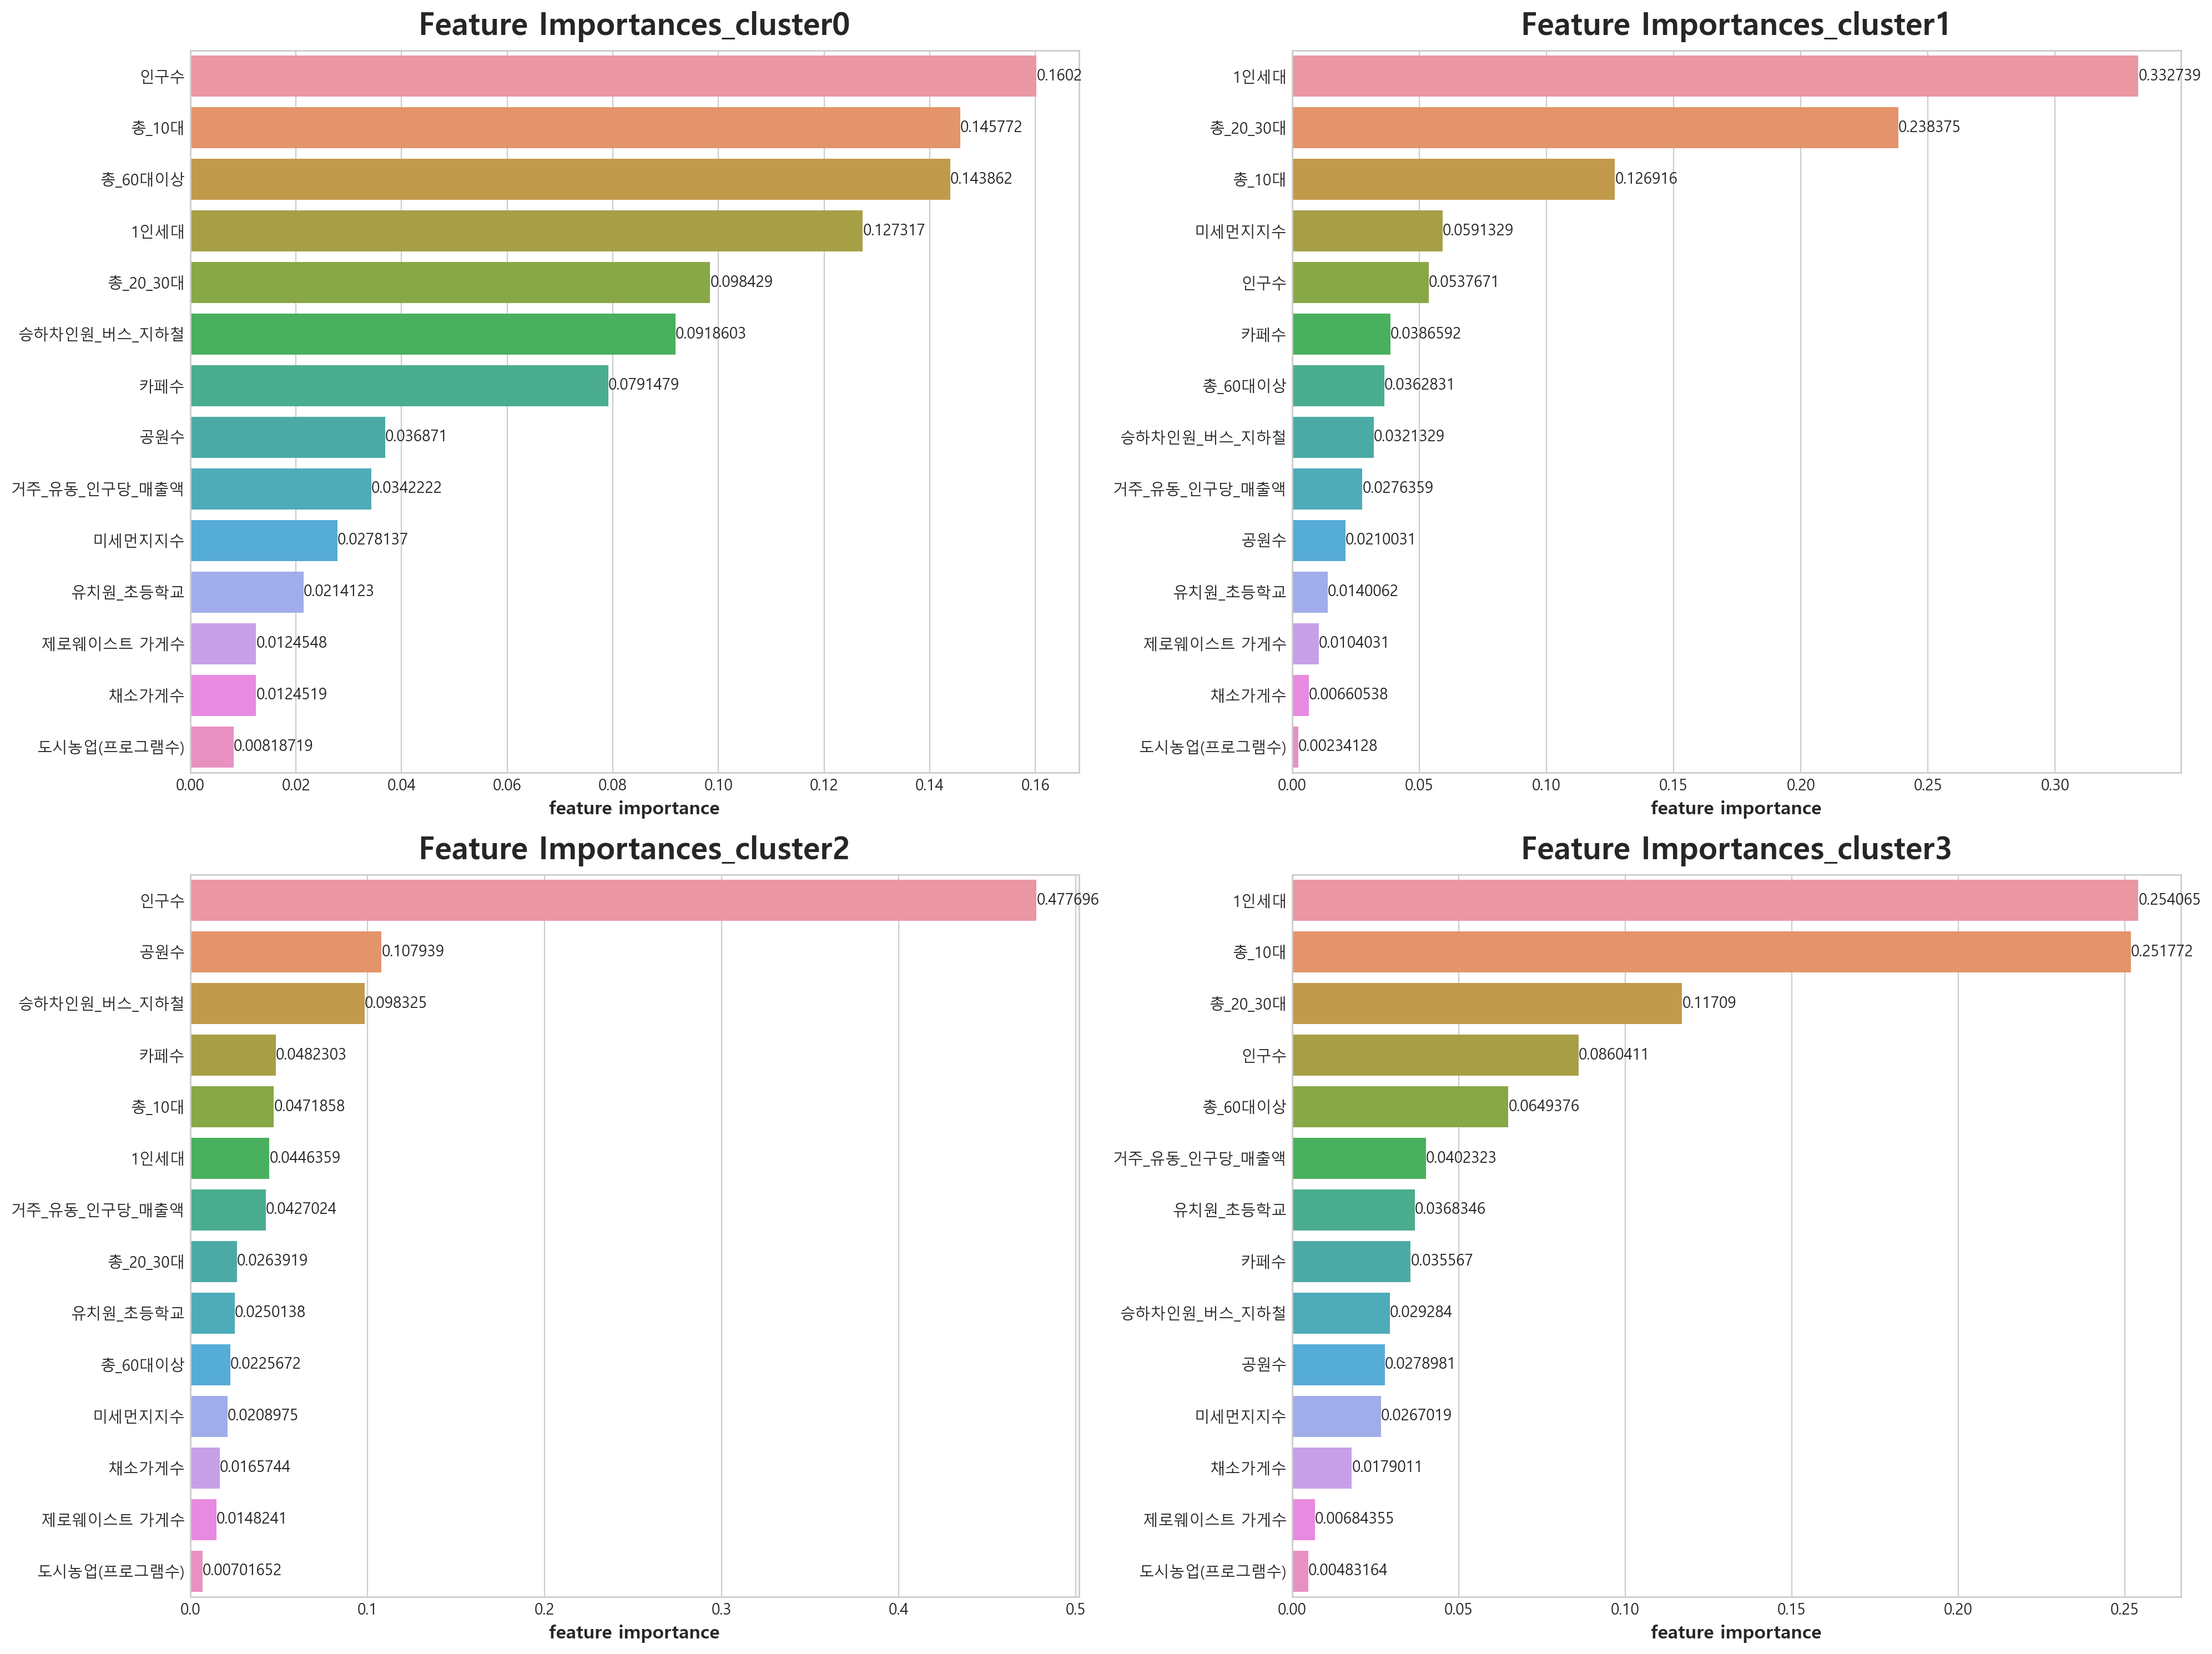

In [11]:
fig, axes = plt.subplots(nrows=2 ,ncols=2,
                          figsize=(20,15))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, 
                    top=0.99, wspace=None, hspace=0.2)
ax = axes.flatten()

for i in range(len(pca_result['cluster'].unique())):
    sns.barplot(x=check_feature_importance(original_df_label, f'binary_cluster_{i}')['feature importance'], 
            y=check_feature_importance(original_df_label, f'binary_cluster_{i}').index, ax=ax[i])
    ax[i].set_title(f"Feature Importances_cluster{i}", fontsize= 20)
    ax[i].bar_label(ax[i].containers[0], fontsize=10);

plt.show()

- minmax scaled data 활용

In [14]:
# randomforest classification을 위한 데이터 준비
scaled_df_label['binary_cluster_0'] = scaled_df_label['cluster'].map({0:1, 1:0, 2:0, 3:0})
scaled_df_label['binary_cluster_1'] = scaled_df_label['cluster'].map({0:0, 1:1, 2:0, 3:0})
scaled_df_label['binary_cluster_2'] = scaled_df_label['cluster'].map({0:0, 1:0, 2:1, 3:0})
scaled_df_label['binary_cluster_3'] = scaled_df_label['cluster'].map({0:0, 1:0, 2:0, 3:1})
scaled_df_label.sample(3)

미세먼지지수       공원수  도시농업(프로그램수)  거주_유동_인구당_매출액     채소가게수  제로웨이스트 가게수  \
행정동명                                                                         
청구동   0.006927  0.038462     0.000000       0.029878  0.046512         0.0   
서빙고동  0.192505  0.115385     0.272727       0.001174  0.011628         0.0   
중앙동   0.016148  0.076923     0.000000       0.027463  0.023256         0.0   

      승하차인원_버스_지하철       카페수  유치원_초등학교       인구수     총_10대  총_20_30대  \
행정동명                                                                   
청구동       0.024668  0.034483  0.350770  0.237509  0.258604  0.435515   
서빙고동      0.097415  0.022167  0.275032  0.221609  0.490859  0.360753   
중앙동       0.183471  0.078818  0.149691  0.300304  0.158538  0.762405   

       총_60대이상      1인세대  cluster  binary_cluster_0  binary_cluster_1  \
행정동명                                                                    
청구동   0.667661  0.431969        0                 1                 0   
서빙고동  0.524943  0.322462        3                 0                 0   
중앙동   0.472212  0.819048        1                 0                 1   

      binary_cluster_2  binary_cluster_3  
행정동명                                      
청구동                  0                 0  
서빙고동                 0                 1  
중앙동                  0                 0

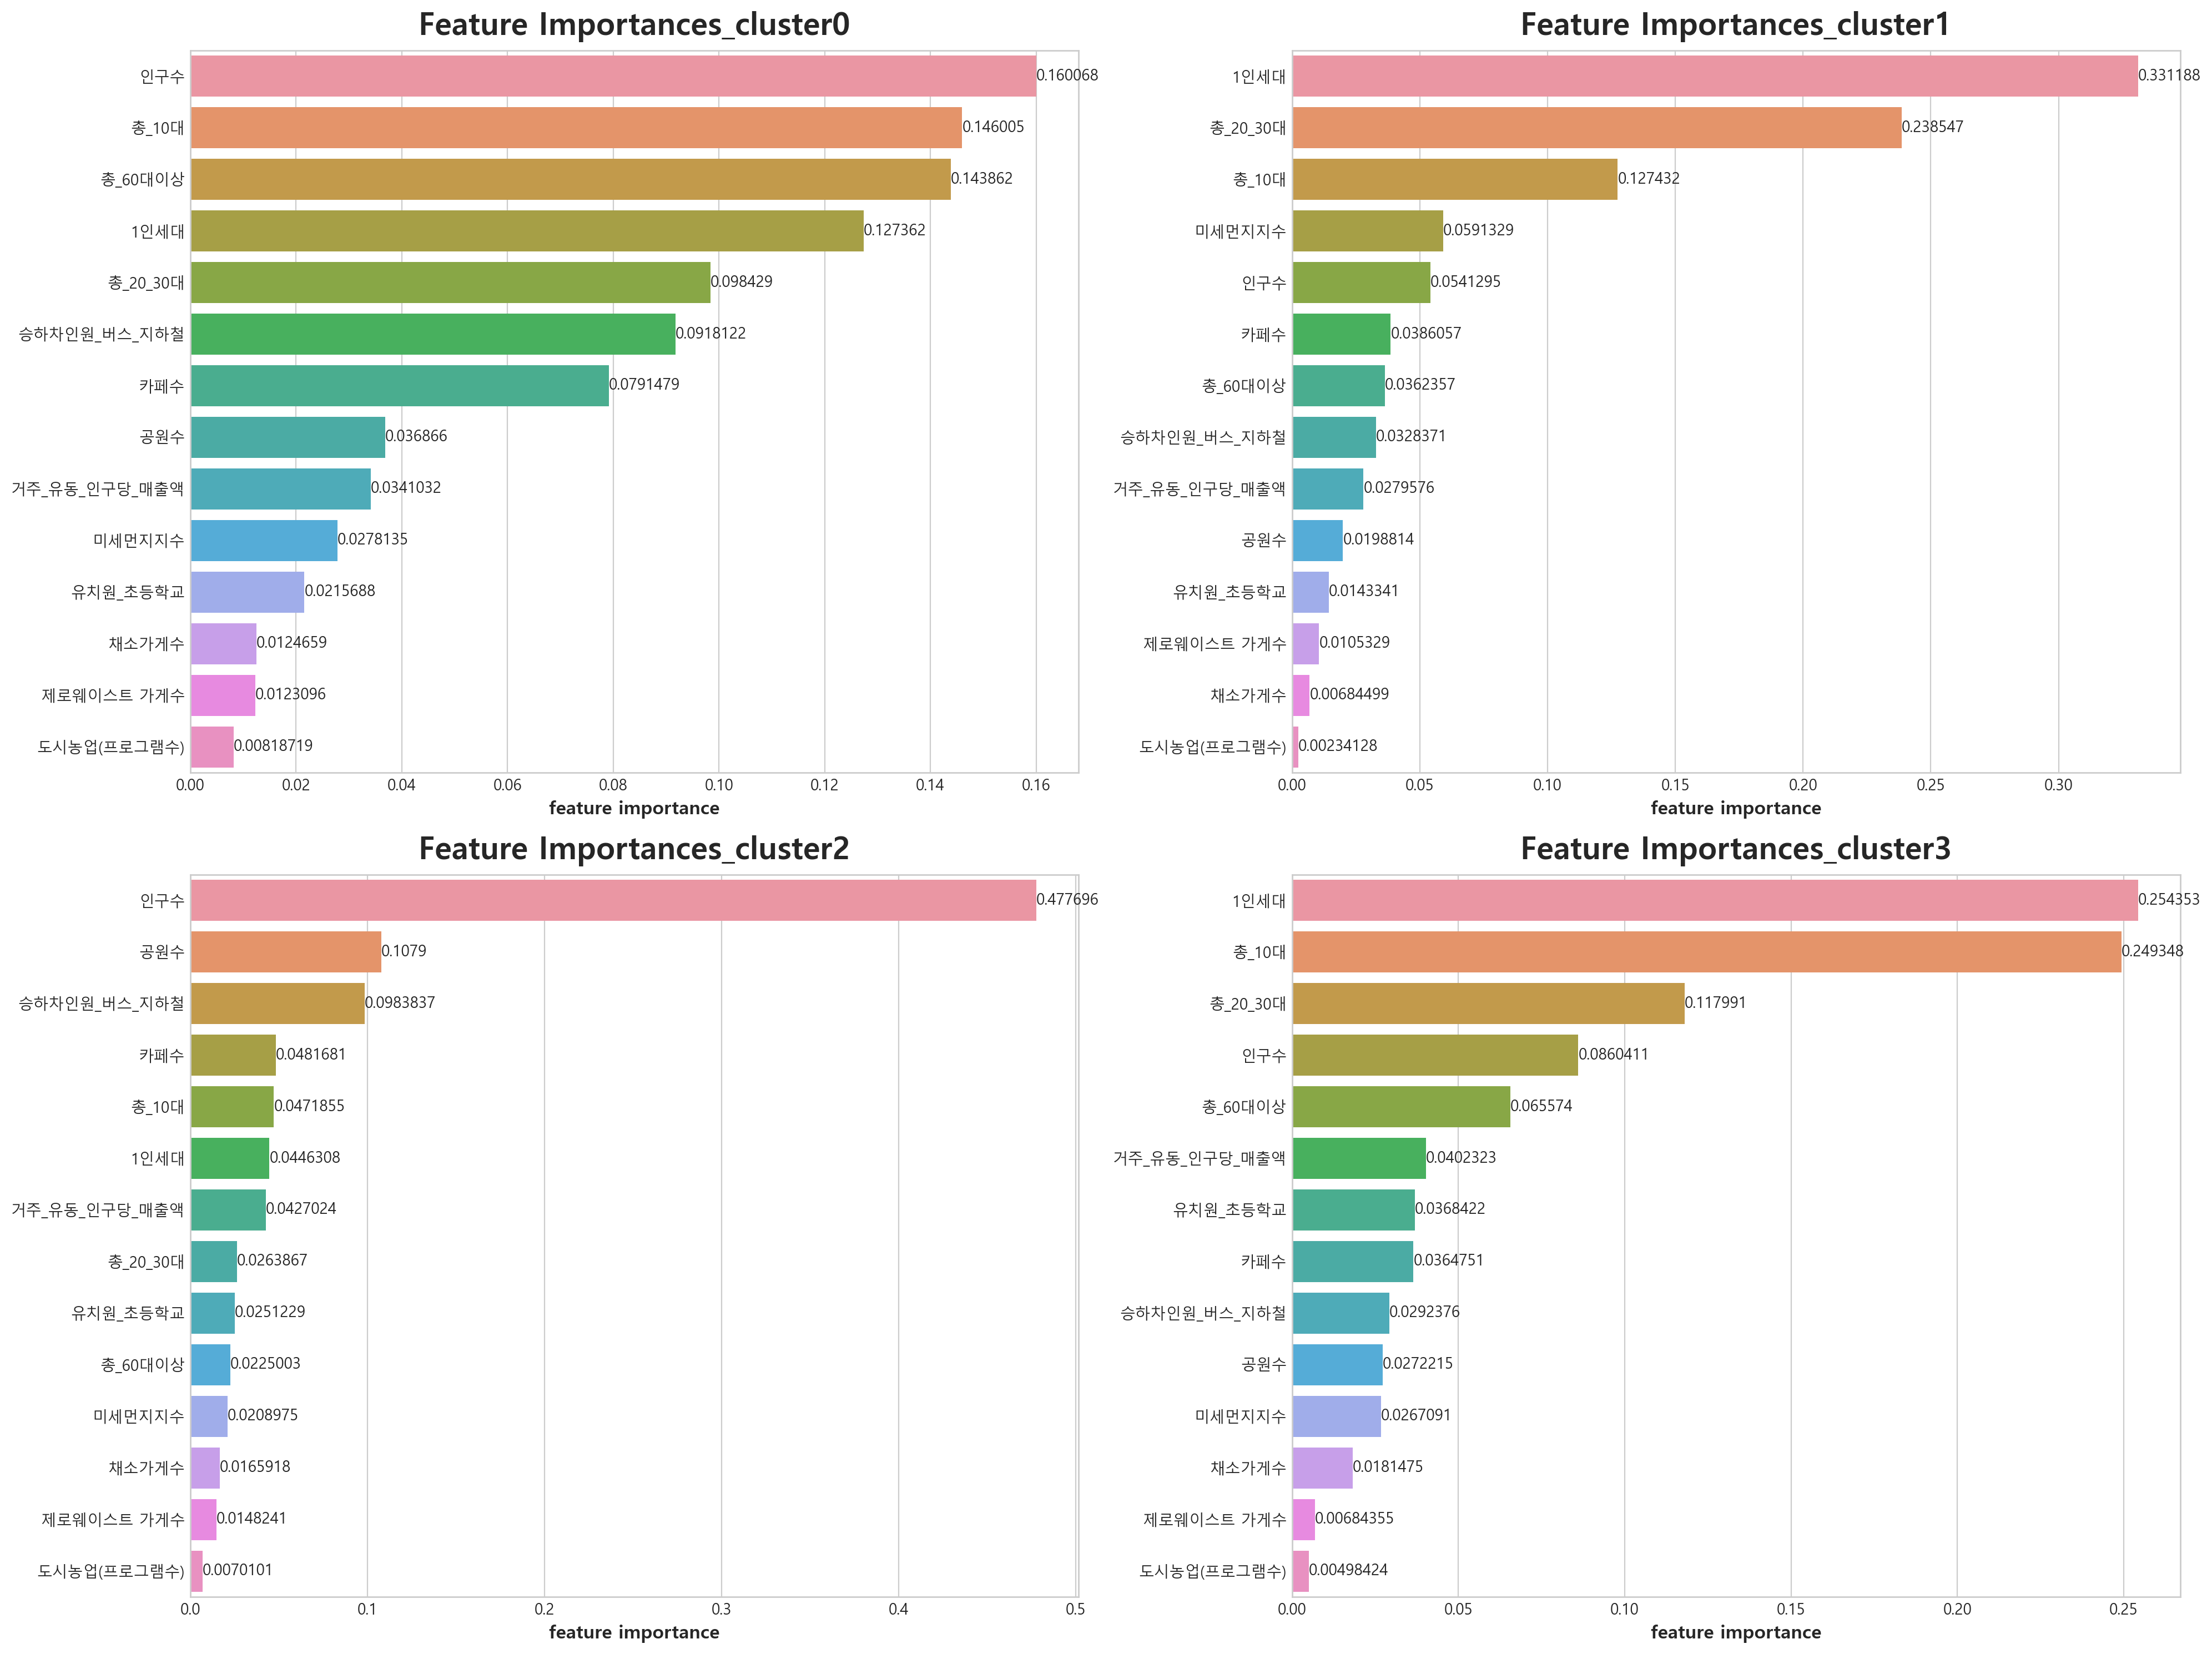

In [16]:
fig, axes = plt.subplots(nrows=2 ,ncols=2,
                          figsize=(20,15))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, 
                    top=0.99, wspace=None, hspace=0.2)
ax = axes.flatten()

for i in range(len(pca_result['cluster'].unique())):
    sns.barplot(x=check_feature_importance(scaled_df_label, f'binary_cluster_{i}')['feature importance'], 
            y=check_feature_importance(scaled_df_label, f'binary_cluster_{i}').index, ax=ax[i])
    ax[i].set_title(f"Feature Importances_cluster{i}", fontsize= 20)
    ax[i].bar_label(ax[i].containers[0], fontsize=10);

plt.show()